In [3]:
from ml import *
# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import imblearn

In [ ]:
# label_df = pd.read_pickle("../pickles/upsampled_users/user_df_labelled_5_new.pickle")
# label_df = label_df[label_df.category != 'mixed']
# #label_df = label_df.reset_index()
# val_df = label_df[30000:42114]
# val_df.to_pickle("./val_df.pickle")
# label_df = label_df[0:30000]

In [14]:
label_df = pd.read_pickle("../pickles/upsampled_users/user_df_labelled_10.pickle")
label_df = label_df[label_df.category != 'mixed']
label_df = label_df[label_df.category != 'unknown']

In [15]:
label_df = label_df.drop(columns = [
       'num_receiving_tx_b',  'num_sending_tx_b', 
       'num_tx_a', 'num_tx_b', 'total_rec_a', 'total_rec_b',
       'total_rec_t',  'total_sent_a', 'total_sent_b',
       'total_sent_t', 'unique_rec_adr_b',
       'unique_rec_b', 'unique_rec_user_b',
       'unique_sent_adr_b', 'unique_sent_b',
       'unique_sent_user_b'])

In [16]:
Y = label_df.category
X = label_df.drop(columns = ["category"])
X, X_val, Y, y_val = train_test_split(X, Y, test_size = 0.1)

In [ ]:
X['category'] = Y
label_df = X
x1 = label_df.loc[label_df['category']=='exchanges']
x2 = label_df.loc[label_df['category']=='gambling']
x3 = label_df.loc[label_df['category']=='pool']

## Visualise Correlation

In [ ]:
data_correlation = label_df.corr(method='spearman')
print("correlation: ")
data_correlation.style.format("{:.2}").background_gradient(cmap=plt.cm.Greens, axis=1)

In [ ]:
data_correlation[(abs(data_correlation) > 0.8) & ( data_correlation != 1.0)].dropna(how="all", axis=(0,1))

In [ ]:
indices = data_correlation.index
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(data_correlation, vmin=-1, vmax=1, cmap=plt.cm.Greens)
fig.colorbar(cax)
ticks = np.arange(0,len(indices),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(indices, fontsize=8)
ax.set_yticklabels(indices, fontsize=8)
plt.grid()
plt.savefig("correlation_matrix.pdf")

## Visualize class imbalance

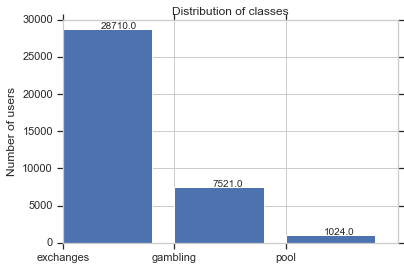

In [10]:
class_hist(label_df)

## Downsampling

In [ ]:
def downsample(big_class, small_class):
    indices = np.arange(big_class.shape[0])
    random_indices = np.random.choice(indices, size = small_class.shape[0])
    downsampled_class = big_class.iloc[random_indices] # choose random staying customers
    return downsampled_class

x1 = downsample(x1,x3)
x2 = downsample(x2,x3)

temp = pd.concat([x1, x2])
df = pd.concat([temp,x3])

# df = df.reset_index()
# df = df.sort_values(by=['index'])
# df = df.drop(columns = ["index","user"])
#Shuffling all data
Y = df.category
#Y = LabelEncoder().fit_transform(Y)
#classes, Y = np.unique(Y, return_inverse=True)
X = df.drop(columns = ["category"])

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

In [ ]:
#Keeping time element
# X_1 = df[0:35000]
# X_2 = df[35000:40000]
# y_train = X_1.category
# y_test = X_2.category
# X_train = X_1.drop(columns=['category'])
# X_test = X_2.drop(columns=['category'])

## Decision Tree

In [ ]:
dec_tree_classifier, y_pred = get_best_dec_tree(X_train=X_train, y_train=y_train,
                                       X_test=X_test, y_test=y_test)

#sum(y_pred == y_test) / len(y_test)
# import pickle
# # now you can save it to a file
# with open('dt_gambling.pickle', 'wb') as f:
#     pickle.dump(dec_tree_classifier, f)
    
scores(y_test, y_pred)
print("saving confusion matrix for decision tree...")
plot_confusion_matrix(y_test, y_pred, "decision_tree_downsampled_conf_matrix")

In [ ]:
##test on unseen data
print(Counter(y_val))
y_val_pred = dec_tree_classifier.predict(X_val)
scores(y_val, y_val_pred)
plot_confusion_matrix(y_val, y_val_pred, "decision_tree_downsampled_conf_matrix")

Accuracy: 0.8531937734836286
Recall: [0.89491877 0.70867209 0.70526316]
Precision: [0.91841078 0.67746114 0.4962963 ]
f1 score: [0.90651261 0.69271523 0.5826087 ]


/homes/ac2917/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


confusion matrix normalized: 


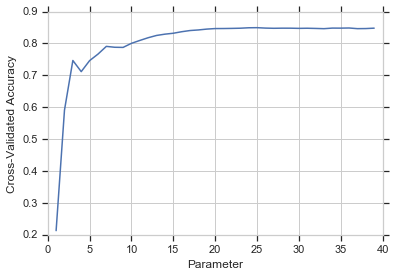

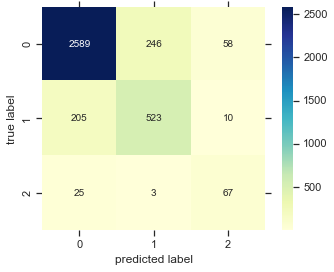

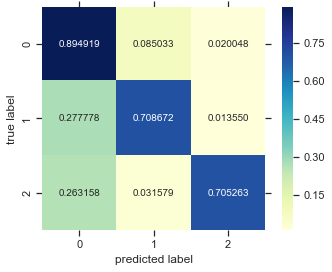

In [11]:
##Cross Validation + Grid Search
dec_tree = tree.DecisionTreeClassifier(random_state=42, class_weight="balanced")
param_grid = dict(max_depth=list(range(1, 40)))

best_params = get_best_estimator_params(dec_tree, param_grid, X,Y)

dec_tree = tree.DecisionTreeClassifier(max_depth = best_params['max_depth'], random_state=42,  class_weight="balanced")
dec_tree.fit(X, Y)

y_val_pred = dec_tree.predict(X_val)

scores(y_val, y_val_pred)
plot_confusion_matrix(y_val, y_val_pred, "decision_tree_downsampled_conf_matrix")

In [ ]:
feature_plot(list(X.columns),dec_tree.feature_importances_)

## Visualize Decision Tree upto a few depth layers

In [ ]:
print("save decision tree with few depth layers for visualization: ")
dec_tree = tree.DecisionTreeClassifier(max_depth = 4, random_state=42, class_weight="balanced")
dec_tree = dec_tree.fit(X, Y)
y_pred = dec_tree.predict(X_val)
print(accuracy_score(y_val, y_pred))
plot_dec_tree(dec_tree, feature_names=X.columns, filename="Decision Tree")
plot_confusion_matrix(y_val, y_pred, "decision_tree_downsampled_conf_matrix")
scores(y_val, y_pred)

## Random Forest

In [ ]:
rf_classifier, y_pred = get_best_random_forest(X_train=X_train, y_train=y_train,
                                       X_test=X_test, y_test=y_test)

In [ ]:
print("saving confusion matrix ...")
plot_confusion_matrix(y_test, y_pred, "random_forest_conf_mat.pdf")

In [ ]:
##test on unseen data
print(Counter(y_val))
y_val_pred = rf_classifier.predict(X_val)
scores(y_val, y_val_pred)
plot_confusion_matrix(y_val, y_val_pred, "decision_tree_downsampled_conf_matrix")

Accuracy: 0.8784219001610306
Recall: [0.94344205 0.66977364 0.5483871 ]
Precision: [0.9051265  0.75639098 0.89473684]
f1 score: [0.92388719 0.71045198 0.68      ]
confusion matrix normalized: 


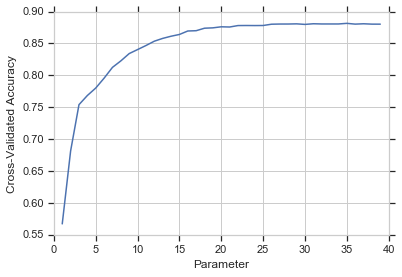

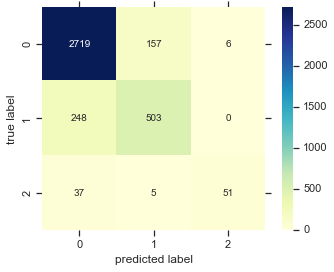

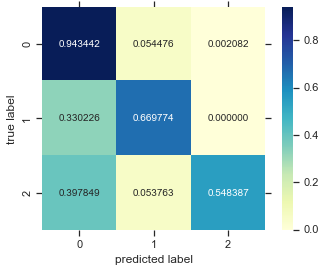

In [17]:
## Cross Val + Grid Search

rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = dict(max_depth=list(range(1, 40)))

best_params = get_best_estimator_params(rf, param_grid, X,Y)

rf = RandomForestClassifier(max_depth = best_params['max_depth'], random_state=42,  class_weight="balanced")
rf.fit(X, Y)

y_val_pred = rf.predict(X_val)

scores(y_val, y_val_pred)
plot_confusion_matrix(y_val, y_val_pred, "Random Forest CM")

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_information = mutual_info_classif(X, Y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(list(X.columns), rotation=45, ha='right', fontsize=12)
plt.suptitle("Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

In [ ]:
from sklearn.feature_selection import GenericUnivariateSelect
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
X_trans = trans.fit_transform(X, Y)
print("We started with {0} features but retained only {1} of them!".format(len(X.columns), X_trans.shape[1]))

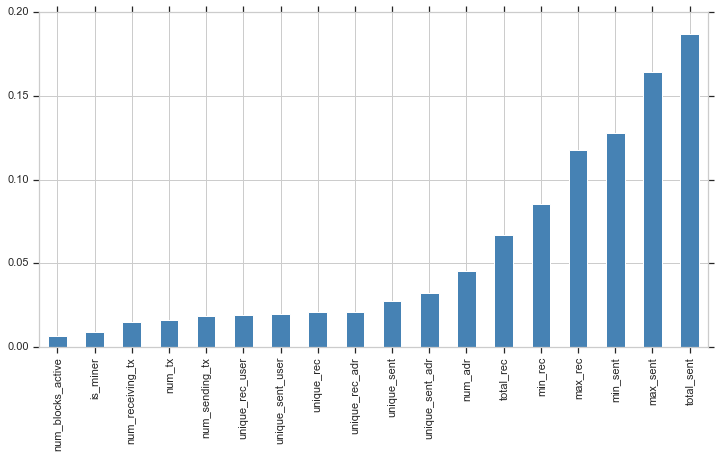

In [18]:
feature_plot(list(X.columns),rf.feature_importances_)

## Normalise Data

In [ ]:
X_min_max, X_standard = normalize(X)

In [ ]:
X_val_min_max, X_val_standard = normalize(X_val)

In [ ]:
pca_and_plot(X_train=X, y_train=Y)

In [ ]:
pca_and_plot(X_train=X_train_standard, y_train=y_train)

In [ ]:
pca_and_plot(X_train=X_train_min_max, y_train=y_train)

### Nearest neighbour classification on PCA data  

In [ ]:
knn, pca, principalComponents, principalComponentsTest, y_pred = get_best_pca_components(X_train=X_standard, y_train=Y,
                                       X_test=X_val_standard, y_test=y_val)
scores(y_val, y_pred)
plot_confusion_matrix(y_val, y_pred, "knn_conf_matrix")

## LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_result = lda.fit(X, Y).transform(X)
y_pred = lda.predict(X_val)
scores(y_val, y_pred)

## t-SNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

In [ ]:
tsne = TSNE()
tsne_result = tsne.fit_transform(X_train_standard,y_train)


In [ ]:
plt.figure()
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0,1], [0,1]):
    plt.scatter(tsne_result[y_train == i,0], tsne_result[y_train == i,1], alpha=.8, color=color,label=target_name)
plt.legend(labels=["0","1"])

In [ ]:
isomap = Isomap(10,2)

In [ ]:
isomap_result = isomap.fit_transform(X_train_standard)
# isomap_result.dump("isomap_result.pickle")
# isomap_result = np.load("isomap_result.pickle")

In [ ]:
plt.figure()
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0,1], [0,1]):
    plt.scatter(isomap_result[y_train == i,0], isomap_result[y_train == i,1], alpha=.8, color=color,label=target_name)
plt.legend(labels=["0","1"])

## SVM

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_standard, y_train)  
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

### Logistic regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_standard,y_train)
y_pred = logisticRegr.predict(X_test_standard)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))